# Along-isopycnal Anomaly Analysis

Using the Ocean Observatories Initative slope-base (RS01SBPS) and offshore (CE04OSPS) profilers, this notebook calculates the along-isopycnal variability in temperature, salinity, spice, and oxygen of the offshore profiler relative to the long-term mean of the slope-base profiler.

In [1]:
import calendar
from pathlib import Path

import gsw
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from cycler import cycler
from numpy.typing import NDArray
from scipy.signal import find_peaks
from tqdm import tqdm
from xarray.groupers import BinGrouper

## Function for QC and Binning of Profiler Data

These functions handle the download, QC and binning of profiler data. The only QC performed is applying the included QARTOD flags and removing some large salinity/temperature values (>40 PSU and >30oC, respectively). The binning is done by using a peak finding algorithm to identify peaks in the depth of the profiler, through which profiles are then split (which typically take ~3 hours at ~2 cm/s). These profiles are then binned in depth into 2 m depth bins.

In [2]:
def split_profiles_by_peaks(ds: xr.Dataset, **kwargs) -> list[xr.Dataset]:
    """
    Split the data set into individual profiles, where each profile is a
    collection of data from a single deployment and profile sequence. The
    resulting data sets are returned in a list. The profiles are split based
    on the location of the peaks in depth (technically, the negative of depth,
    so that deepest depths are most positive) in the data set.

    :param ds: data set containing the profile data
    :param kwargs: keyword arguments to pass to find_peaks
    :return: a list of data sets, one for each profile
    """
    peaks, _ = find_peaks(-ds["z"], **kwargs)
    profiles = []
    for beg, end in zip(tqdm(peaks[:-1], desc="Splitting profiles"), peaks[1:]):
        profiles.append(ds.isel(time=slice(beg, end)))
    return profiles


def profiler_binning(
    ds: xr.Dataset,
    z_bins: NDArray[np.float64] | NDArray[np.int_],
    z_lab: str = "depth",
    t_lab: str = "time",
    offset: float = 0.5,
    **kwargs,
) -> xr.Dataset:
    """
    Bins a profiler time series into daily bins and depth bins.
    Removes any non-numeric data types, including any time types,
    outside of the coordinates.

    input:
    d = xr.Dataset with coordinates depth and time
    z = depth bins array
    z_lab, t_lab = labels for depth, time in d

    returns:
    Binned xr.Dataset
    Args:
        d (xr.dataset): OOI profiler dataset
        z (array): edges of depth/pressure bins
        z_lab (str, optional): name of depth/pressure in dataset. Defaults to 'depth'.
        t_lab (str, optional): name of time in dataset. Defaults to 'time'.
        offset (float, optional): Distance from location to CTD (positive when CTD is higher).
            Defaults to 0.5.

    Returns:
        xr.dataset: binned dataset
    """
    peaks, _ = find_peaks(-ds[z_lab], **kwargs)
    time_bins = ds[t_lab].isel(time=peaks)  # bin edges
    time_centers = np.diff(time_bins.values) / 2 + time_bins.values[:-1]  # bin centers
    z_centers = np.diff(z_bins) / 2 + z_bins[:-1]  # bin centers
    ds = ds.groupby(
        {
            f"{t_lab}": BinGrouper(bins=time_bins.values, labels=time_centers),
            f"{z_lab}": BinGrouper(bins=z_bins, labels=z_centers),
        }
    ).mean()
    return ds


def download_ooi_errdap(site: str, refdes: str, delete_existing: bool = False) -> Path:
    directory = Path("../data")
    requested_file_name = f"{site.lower()}-{refdes.lower()}.nc"
    url = f"https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-{requested_file_name}"
    file_name = Path(requested_file_name)
    if Path(directory / file_name).is_file() and not delete_existing:
        print(f"File {file_name} already exists.")
        return Path(directory / file_name)
    with open(directory / file_name, "wb") as file:
        response = requests.get(url, timeout=(5, 300))
        file.write(response.content)
    return Path(directory / file_name)


def qc(ds: xr.Dataset) -> xr.Dataset:
    # Make time primary dimension and reduce lat/lon to mean
    ds = ds.swap_dims({"row": "time"})
    ds["longitude"] = ds["longitude"].mean(dim="time")
    ds["latitude"] = ds["latitude"].mean(dim="time")
    # Rename and use only these variables
    rename_dict = {
        "sea_water_electrical_conductivity_profiler_depth_enabled": "conductivity",
        "sea_water_electrical_conductivity_profiler_depth_enabled_qc_agg": "conductivity_qc_agg",
        "moles_of_oxygen_per_unit_mass_in_sea_water_profiler_depth_enabled": "oxygen",
        "moles_of_oxygen_per_unit_mass_in_sea_water_profiler_depth_enabled_qc_agg": "oxygen_qc_agg",
        "sea_water_practical_salinity_profiler_depth_enabled": "practical_salinity",
        "sea_water_practical_salinity_profiler_depth_enabled_qc_agg": "practical_salinity_qc_agg",
        "sea_water_density_profiler_depth_enabled": "density",
        "sea_water_density_profiler_depth_enabled_qc_agg": "density_qc_agg",
        "sea_water_pressure_profiler_depth_enabled": "pressure",
        "sea_water_pressure_profiler_depth_enabled_qc_agg": "pressure_qc_agg",
        "sea_water_temperature_profiler_depth_enabled": "temperature",
        "sea_water_temperature_profiler_depth_enabled_qc_agg": "temperature_qc_agg",
    }
    ds = ds.rename_vars(rename_dict)
    # print(ds["pressure"].values)
    # Get new variable names
    variables = list(rename_dict.values())
    # Identify qc or depth variables
    variables = [
        var
        for var in variables
        if not var.endswith("_qc_agg") or var == "z" or var == "station"
    ]
    # Apply qc and range checks
    for var in tqdm(variables):
        ds[var] = ds[var].where(ds[var + "_qc_agg"] <= 2)
        if var == "temperature":
            ds[var] = ds[var].where(ds[var] < 30)
        if var == "practical_salinity":
            ds[var] = ds[var].where(ds[var] < 40)
    # print(ds["pressure"].values)

    # Compute absolute salinity and potential density
    ds["absolute_salinity"] = gsw.SA_from_SP(
        ds["practical_salinity"],
        ds["pressure"],
        ds["longitude"],
        ds["latitude"],
    )
    ds["conservative_temperature"] = gsw.CT_from_t(
        ds["absolute_salinity"],
        ds["temperature"],
        ds["pressure"],
    )
    ds["potential_density_anomaly"] = gsw.density.sigma0(
        ds["absolute_salinity"],
        ds["conservative_temperature"],
    )
    ds["spice"] = gsw.spiciness0(
        ds["absolute_salinity"],
        ds["conservative_temperature"],
    )
    ds = ds.drop_duplicates(dim="time")
    # ds = ds.sel(time=slice(np.datetime64("2016-01-01"), None))
    return ds

In [3]:
# only qc if the dataset is not present to save time
if Path("../data/slope_base_qced.nc").is_file():
    slope_base = xr.open_dataset("../data/slope_base_qced.nc")
else:
    slope_file = download_ooi_errdap("RS01SBPS", "SF01A-2A-CTDPFA102")
    slope_base = xr.open_dataset(slope_file)
    slope_base = qc(slope_base)
    slope_base = slope_base.where(
        (slope_base["z"] > -200) & (slope_base["z"] < 0), drop=True
    )
    slope_base.to_netcdf("../data/slope_base_qced.nc")


if Path("../data/offshore_qced.nc").is_file():
    offshore = xr.open_dataset("../data/offshore_qced.nc")
else:
    offshore_file = download_ooi_errdap("CE04OSPS", "SF01B-2A-CTDPFA107")
    offshore = xr.open_dataset(offshore_file)
    offshore = qc(offshore)
    offshore = offshore.where((offshore["z"] > -200) & (offshore["z"] < 0), drop=True)
    offshore.to_netcdf("../data/offshore_qced.nc")

## Example of the Peak Finding Binning Algorithm

This plot shows how the peak finding algorithm identifies peaks in depth which are then used to split the profiles.

(np.float64(17972.0), np.float64(17973.0))

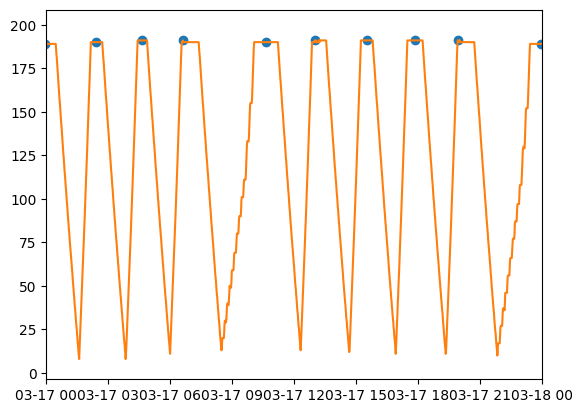

In [4]:
slope_peaks, _ = find_peaks(
    x=-slope_base["z"], height=100, distance=100, prominence=100
)
plt.plot(
    slope_base.isel(time=slope_peaks)["time"],
    -slope_base["z"].isel(time=slope_peaks),
    "o",
)
plt.plot(slope_base["time"], -slope_base["z"])
plt.xlim(np.datetime64("2019-03-17"), np.datetime64("2019-03-18"))

## Binning the Slope Base Profiler Data

Next, we bin the slope base profiler data in preparation of computing monthly climatologies and the long-term mean.

In [5]:
# only bin if the dataset is not present to save time
if Path("../data/slope_base_binned.nc").is_file():
    slope_base_binned = xr.open_dataset("../data/slope_base_binned.nc")
else:
    slope_base_binned = profiler_binning(
        slope_base,
        np.arange(-200, 0, 2),
        z_lab="z",
        t_lab="time",
        offset=0,
        height=100,
        distance=100,
        prominence=100,
    )
    slope_base_binned = slope_base_binned.rename(
        {"time_bins": "time", "z_bins": "depth"}
    )
    slope_base_binned.to_netcdf("../data/slope_base_binned.nc")

In [6]:
slope_base_climatology = slope_base_binned.groupby("time.month").mean(dim="time")
slope_base_climatology

<xarray.Dataset> Size: 238kB
Dimensions:                                                                     (
                                                                                 month: 12,
                                                                                 depth: 99)
Coordinates:
  * depth                                                                       (depth) float64 792B ...
  * month                                                                       (month) int64 96B ...
Data variables: (12/25)
    latitude                                                                    (month, depth) float64 10kB ...
    longitude                                                                   (month, depth) float64 10kB ...
    z                                                                           (month, depth) float64 10kB ...
    conductivity                                                                (month, depth) float64 10kB ...
    conductivity_qc_agg                                                         (month, depth) float64 10kB ...
    sea_water_electrical_conductivity_profiler_depth_enabled_qc_tests           (month, depth) float64 10kB ...
    ...                                                                          ...
    temperature_qc_agg                                                          (month, depth) float64 10kB ...
    sea_water_temperature_profiler_depth_enabled_qc_tests                       (month, depth) float64 10kB ...
    absolute_salinity                                                           (month, depth) float64 10kB ...
    conservative_temperature                                                    (month, depth) float64 10kB ...
    potential_density_anomaly                                                   (month, depth) float64 10kB ...
    spice                                                                       (month, depth) float64 10kB ...
Attributes: (12/52)
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    ...                            ...
    station_id:                    104287
    summary:                       Timeseries data from 'Regional Cabled Arra...
    time_coverage_end:             2025-04-08T08:27:00Z
    time_coverage_start:           2014-10-06T22:05:00Z
    title:                         Regional Cabled Array: Oregon Slope Base S...
    Westernmost_Easting:           -125.389899

In [7]:
def plot_climatology(x, y, xlabel, ylabel) -> None:
    """Helper function to plot climatology data."""
    fig, ax = plt.subplots()
    ax.set_prop_cycle(cycler("color", cm.viridis(np.linspace(0, 1, 12))))  # type: ignore
    for i in range(12):
        ax.plot(x[i], y[i], label=calendar.month_name[i + 1])
    x_mean = np.mean(x, axis=0)
    y_mean = np.mean(y, axis=0)
    ax.plot(x_mean, y_mean, color="k", label="Mean", linewidth=2)
    ax.set_ylim(24.25, 26.75)
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.invert_yaxis()

## Slope Base Climatology Plots

These are plots of the monthly climatologies and long-term mean of the temperature, salinity, spice, and oxygen as a function of potential density anomaly. Note that the y-axis (potential density anomaly) is inverted to reflect that higher densities correspond to deeper waters.

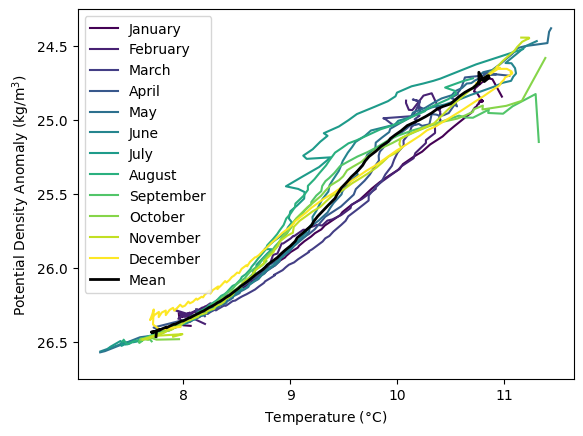

In [8]:
plot_climatology(
    slope_base_climatology["temperature"],
    slope_base_climatology["potential_density_anomaly"],
    "Temperature ($\\mathsf{\\degree C}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig("../presentation/slope_base_temperature.png", dpi=600, bbox_inches="tight")

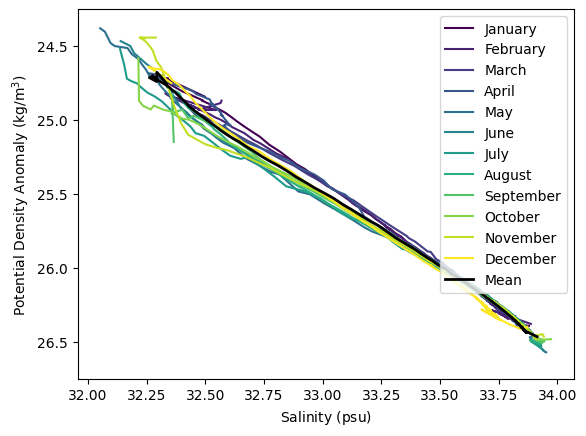

In [9]:
plot_climatology(
    slope_base_climatology["practical_salinity"],
    slope_base_climatology["potential_density_anomaly"],
    "Salinity ($\\mathsf{psu}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig("../presentation/slope_base_salinity.png", dpi=600, bbox_inches="tight")

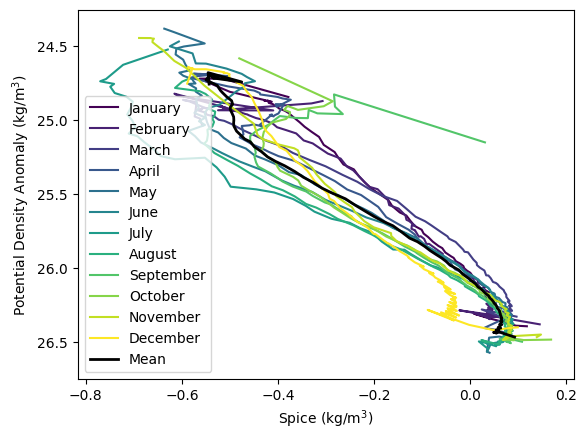

In [10]:
plot_climatology(
    slope_base_climatology["spice"],
    slope_base_climatology["potential_density_anomaly"],
    "Spice ($\\mathsf{kg/m^3}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig("../presentation/slope_base_spice.png", dpi=600, bbox_inches="tight")

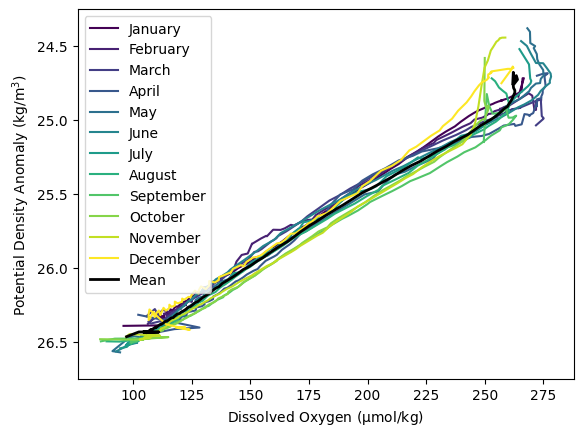

In [11]:
plot_climatology(
    slope_base_climatology["oxygen"],
    slope_base_climatology["potential_density_anomaly"],
    "Dissolved Oxygen ($\\mathsf{\\mu mol/kg}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig("../presentation/slope_base_oxygen.png", dpi=600, bbox_inches="tight")

In [12]:
slope_base_mean = slope_base_binned.mean(dim="time")

## Calculating the Along-Isopycnal Anomaly

Assuming that the slope base site is representative of the conditions of the open ocean, we now subtract the temperature, salinity, spice, and oxygen data of the slope base profiler from the offshore profiler. This subtraction is performed along isopycnals, meaning that first we linearly interpolate the mean slope base climatologies as a function of potential density anomaly, and apply these interpolations to each of the potential density measurements from the offshore profiler. These interpolated water properties are then subtracted from each of the measurements at the offshore site to obtain an along-isopycnal anomaly relative to the slope base site. Finally, the along-isopycnal anomaly offshore data is binned and plotted as for the slope base profiler above.

In [13]:
# get rid of any nans which break the interpolationa
slope_base_mean = slope_base_mean.where(
    (~np.isnan(slope_base_mean["temperature"]))
    & (~np.isnan(slope_base_mean["practical_salinity"]))
    & (~np.isnan(slope_base_mean["oxygen"]))
    & (~np.isnan(slope_base_mean["potential_density_anomaly"]))
    & (~np.isnan(slope_base_mean["spice"])),
    drop=True,
)
# interpolation must be sorted or else it quietly breaks
idx = np.argsort(slope_base_mean["potential_density_anomaly"].values)
slope_base_mean = slope_base_mean.isel(depth=idx)

In [14]:
# interpolation of offshore temp, salinity, spice, and oxygen based on potential density surface
# to disable extrapolation, set right and left to a very large number and nan out afterwards
# setting right and left directly to nan breaks the interpolation function entirely
temp_interp = np.interp(
    offshore["potential_density_anomaly"],
    slope_base_mean["potential_density_anomaly"],
    slope_base_mean["temperature"],
    right=1e10,
    left=1e10,
)
temp_interp[temp_interp > 1e9] = np.nan
sal_interp = np.interp(
    offshore["potential_density_anomaly"],
    slope_base_mean["potential_density_anomaly"],
    slope_base_mean["practical_salinity"],
    right=1e10,
    left=1e10,
)
sal_interp[sal_interp > 1e9] = np.nan
spice_interp = np.interp(
    offshore["potential_density_anomaly"],
    slope_base_mean["potential_density_anomaly"],
    slope_base_mean["spice"],
    right=1e10,
    left=1e10,
)
spice_interp[spice_interp > 1e9] = np.nan
oxy_interp = np.interp(
    offshore["potential_density_anomaly"],
    slope_base_mean["potential_density_anomaly"],
    slope_base_mean["oxygen"],
    right=1e10,
    left=1e10,
)
oxy_interp[oxy_interp > 1e9] = np.nan
dens_interp = np.interp(
    offshore["potential_density_anomaly"],
    slope_base_mean["potential_density_anomaly"],
    slope_base_mean["potential_density_anomaly"],
    right=1e10,
    left=1e10,
)
dens_interp[dens_interp > 1e9] = np.nan

In [15]:
offshore_anomaly = offshore.copy()
offshore_anomaly["temperature"] = offshore_anomaly["temperature"] - temp_interp
offshore_anomaly["practical_salinity"] = (
    offshore_anomaly["practical_salinity"] - sal_interp
)
offshore_anomaly["spice"] = offshore_anomaly["spice"] - spice_interp
offshore_anomaly["oxygen"] = offshore_anomaly["oxygen"] - oxy_interp
offshore_anomaly["potential_density_anomaly_interp_test"] = (
    offshore_anomaly["potential_density_anomaly"] - dens_interp
)
offshore_anomaly["potential_density_anomaly"] = offshore_anomaly[
    "potential_density_anomaly"
].where(
    (~np.isnan(offshore_anomaly["temperature"]))
    & (~np.isnan(offshore_anomaly["practical_salinity"]))
    & (~np.isnan(offshore_anomaly["oxygen"]))
    & (~np.isnan(offshore_anomaly["spice"])),
    drop=True,
)

(np.float64(17972.0), np.float64(17973.0))

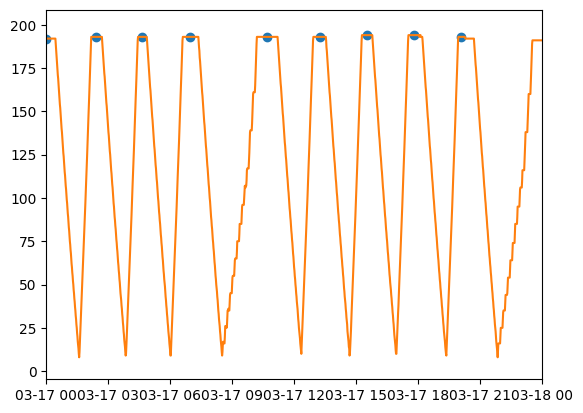

In [16]:
offshore_peaks, _ = find_peaks(
    x=-offshore_anomaly["z"], height=100, distance=100, prominence=100
)
plt.plot(
    offshore_anomaly.isel(time=offshore_peaks)["time"],
    -offshore_anomaly["z"].isel(time=offshore_peaks),
    "o",
)
plt.plot(offshore_anomaly["time"], -offshore_anomaly["z"])
plt.xlim(np.datetime64("2019-03-17"), np.datetime64("2019-03-18"))

In [17]:
offshore_anomaly_binned = profiler_binning(
    offshore_anomaly,
    np.arange(-200, 0, 2),
    t_lab="time",
    z_lab="z",
)
offshore_anomaly_binned = offshore_anomaly_binned.rename(
    {"time_bins": "time", "z_bins": "depth"}
)

In [18]:
offshore_anomaly_climatology = offshore_anomaly_binned.groupby("time.month").mean(
    dim="time"
)

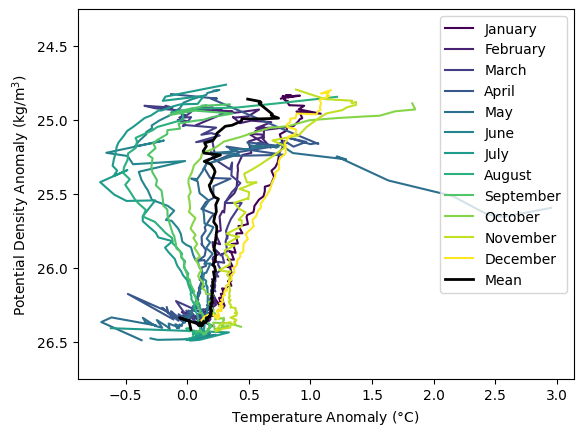

In [19]:
plot_climatology(
    offshore_anomaly_climatology["temperature"],
    offshore_anomaly_climatology["potential_density_anomaly"],
    "Temperature Anomaly ($\\mathsf{\\degree C}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig(
    "../presentation/offshore_temperature_anomaly.png", dpi=600, bbox_inches="tight"
)

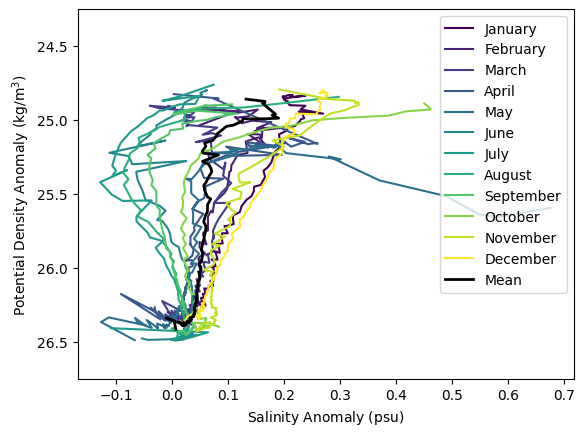

In [20]:
plot_climatology(
    offshore_anomaly_climatology["practical_salinity"],
    offshore_anomaly_climatology["potential_density_anomaly"],
    "Salinity Anomaly ($\\mathsf{psu}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig(
    "../presentation/offshore_salinity_anomaly.png", dpi=600, bbox_inches="tight"
)

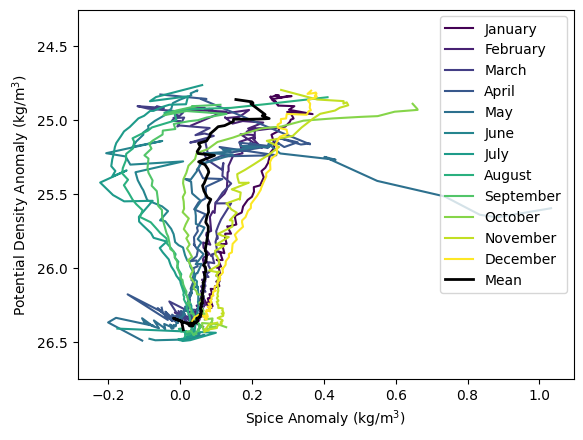

In [21]:
plot_climatology(
    offshore_anomaly_climatology["spice"],
    offshore_anomaly_climatology["potential_density_anomaly"],
    "Spice Anomaly ($\\mathsf{kg/m^3}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig("../presentation/offshore_spice_anomaly.png", dpi=600, bbox_inches="tight")

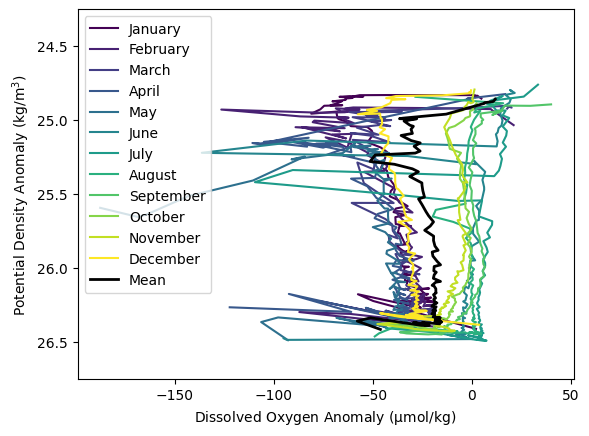

In [22]:
plot_climatology(
    offshore_anomaly_climatology["oxygen"],
    offshore_anomaly_climatology["potential_density_anomaly"],
    "Dissolved Oxygen Anomaly ($\\mathsf{\\mu mol/kg}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig("../presentation/offshore_oxygen_anomaly.png", dpi=600, bbox_inches="tight")

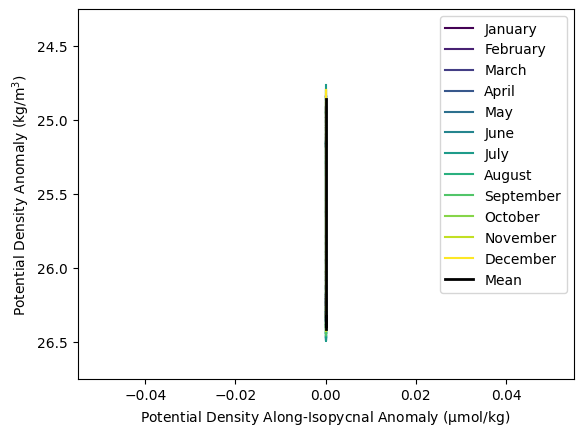

In [23]:
plot_climatology(
    offshore_anomaly_climatology["potential_density_anomaly_interp_test"],
    offshore_anomaly_climatology["potential_density_anomaly"],
    "Potential Density Along-Isopycnal Anomaly ($\\mathsf{\\mu mol/kg}$)",
    "Potential Density Anomaly ($\\mathsf{kg/m^3}$)",
)
plt.savefig(
    "../presentation/offshore_potential_density_anomaly.png",
    dpi=600,
    bbox_inches="tight",
)